<a id="top"></a> 
# Analysis of rhythmic activity *for the practicing neuroscientist*

<div class="question">
    
_**Synopsis**_ 

**Data:** 2 s of scalp EEG data sampled at 1000 Hz.

**Goal:** Characterize the observed rhythms in these data.

**Tools:** Fourier transform, power spectral density, spectrogram.
    
</div>

* [Introduction](#.)
* [Data analysis](#data-analysis)
    1. [Visual inspection](#visual-inspection)
    2. [Mean, variance, and standard deviation](#mean)
    3. [The autocovariance](#autocovariance)
    4. [Power spectral density](#power-spectral-density)
        * [The spectrum](#spectrum)
        * [The discrete Fourier transform in Python](#dft)
        * [The Nyquist frequency](#nyquist-frequency)
        * [The frequency resolution](#frequency-resolution)
    5. [Decibel scaling](#decibel-scaling)
    6. [The spectrogram](#the-spectrogram)
* [Summary](#summary)
---
* [Supplements](#supplements)
    1. [Biased versus unbiased autocovariance](#supplement-acv)
    2. [Intuition behind the power spectral density](#supplement-psd)

In [1]:
# Import the usual suspects ...
from scipy.io import loadmat                    # To load .mat files
import matplotlib.pyplot as plt                 # Load plotting functions
from pylab import *                             # Import plotting functions
from numpy import *                             # Import numerical functions
from IPython.core.pylabtools import figsize     # Allow us to change figure sizes
from IPython.core.display import HTML           # Package for manipulating appearance of notebooks
from IPython.lib.display import YouTubeVideo    # Package for displaying YouTube videos

In [2]:
# ... and the tools that we will need for this chapter
from numpy import where
from numpy.fft import fft, rfft
from scipy.signal import spectrogram

<div class="python-note">
    
Note that the NumPy functions imported in cell number 2 were already imported in the first cell. We explicitly imported them in the second cell so that it's clear that these functions are from the NumPy module.
    
</div>

## On-ramp: computing the  spectrum in Python
We begin this module with an "*on-ramp*" to analysis. The purpose of this on-ramp is to introduce you immediately to a core concept in this module: how to compute a spectrum in Python. You may not understand all aspects of the program here, but that's not the point. Instead, the purpose of this on-ramp is to illustrate what *can* be done. Our advice is to simply run the code below and see what happens ...

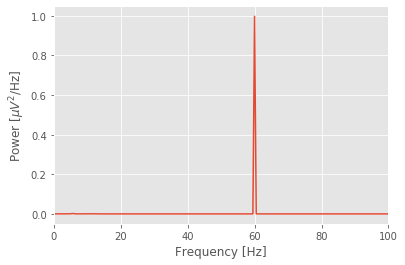

In [3]:
data = loadmat('matfiles/EEG-1.mat')  # Load the EEG data
EEG = data['EEG'].reshape(-1)  # Extract the EEG variable
t = data['t'][0]  # ... and the t variable

x = EEG  # Relabel the data variable
dt = t[1] - t[0]  # Define the sampling interval
N = x.shape[0]  # Define the total number of data points
T = N * dt  # Define the total duration of the data

xf = fft(x - x.mean())  # Compute Fourier transform of x
Sxx = 2 * dt ** 2 / T * (xf * xf.conj())  # Compute spectrum
Sxx = Sxx[:int(len(x) / 2)]  # Ignore negative frequencies

df = 1 / T.max()  # Determine frequency resolution
fNQ = 1 / dt / 2  # Determine Nyquist frequency
faxis = np.arange(0,fNQ,df)  # Construct frequency axis

plot(faxis, Sxx.real)  # Plot spectrum vs frequency
xlim([0, 100])  # Select frequency range
xlabel('Frequency [Hz]')  # Label the axes
ylabel('Power [$\mu V^2$/Hz]')
show()

<div class="question">
    
**Q:** Try to read the code above. Can you see how it loads data, computes the spectrum, and then plots the results?

**A:** If you've never computed a spectrum before, that's an especially difficult question. Please continue on to learn this **and more**!

</div>

## Introduction

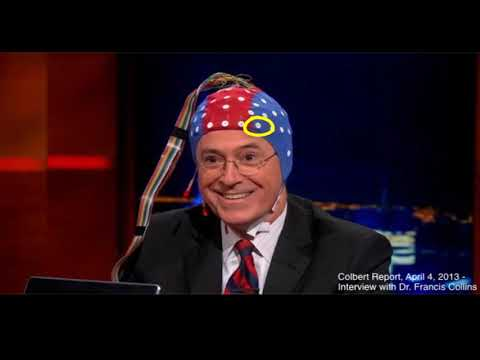

In [4]:
YouTubeVideo('PmGme7YuAiw')
# NO CODE

In this module, we consider data recorded in the scalp [electroencephalogram](https://en.wikipedia.org/wiki/Electroencephalography) or EEG. The EEG provides a measure of brain voltage activity with high temporal resolution (typically on the order of milliseconds) but poor spatial resolution (on the order of 10 cm<sup>2</sup> of cortex). Here we will consider EEG activity recorded from a single scalp electrode. We will analyze these data to determine what (if any) rhythmic activity is present. In doing so, we will learn about an important technique to characterize rhythms in data - the Fourier transform and power spectral density or "spectrum" - and the many subtleties associated with this technique. We begin with a brief description of the data.

### Case study data

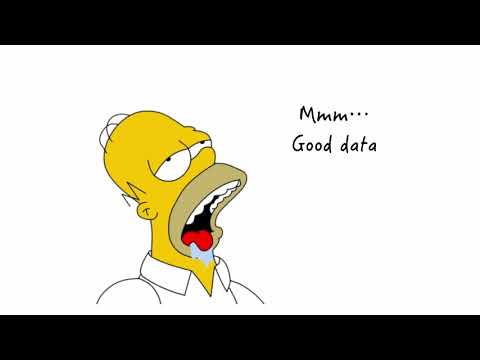

In [5]:
YouTubeVideo('oRCUx11iEck')
# NO CODE

A patient enters the Massachusetts General Hospital (MGH) emergency room unconscious. As part of his clinical workup, electrodes are placed on the scalp surface and the EEG recorded. We assume that the skilled technicians at MGH record the EEG data with no artifacts (i.e., correctly placed electrodes in good electrical contact with the scalp). Twenty-one electrodes simultaneously record the EEG data for 10 minutes sampled at 1000 Hz (i.e., 1000 samples per second). To start, we receive from our clinical collaborator a 2 s snippet of EEG data recorded from a single electrode:
![EEG data recorded from a single electrode](imgs/3-1.png)
If we find anything interesting in this 2 s snippet, our clinical collaborator has promised to provide additional EEG data from this patient and others.

### Goals

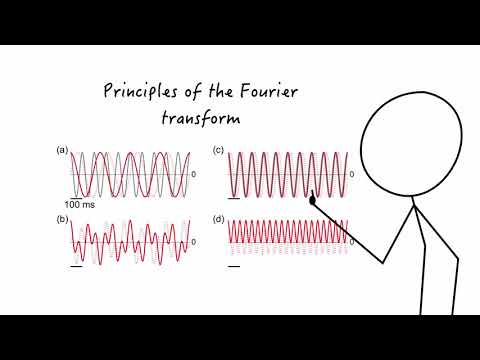

In [6]:
YouTubeVideo('L0xf0dCn7T0')
# NO CODE

The goal of this chapter is to analyze the 2 s of EEG data by characterizing the observed rhythms. By the end of this chapter, you should be familiar with the principles of the Fourier transform, how to compute the spectrum in Python, and the time-windowed spectrum.


### Tools
The primary tool developed in this chapter is the Fourier transform. We will learn how to compute the Fourier transform, and the associated spectrum, in Python. We will see that the spectrum provides a powerful technique to assess rhythmic structure in time series data.

## Data analysis<a id="data-analysis"></a>

We will go through the following steps to analyze the data:

1. [Visual inspection](#visual-inspection)
2. [Mean, variance, and standard deviation](#mean)
3. [The autocovariance](#autocovariance)
4. [Power spectral density](#power-spectral-density)
5. [Decibel scaling](#decibel-scaling)
6. [The spectrogram](#the-spectrogram)

### Step 1: Visual inspection<a id="visual-inspection"></a>

Often, the best place to begin our data analysis is visual inspection of the time series. To do so, let's plot the data:<a id="fig:3.1"></a>

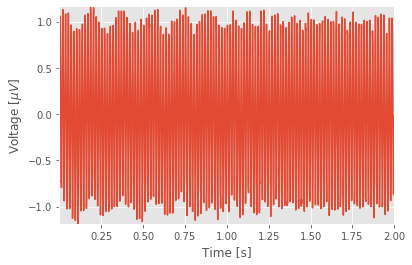

In [7]:
data = loadmat('matfiles/EEG-1.mat')  # Load the EEG data
EEG = data['EEG'][:, 0]  # Extract the EEG variable
t = data['t'][0]  # ... and the t variable

plot(t, EEG)  # Plot the data versus time
xlabel('Time [s]')  # Label the time axis
ylabel('Voltage [$\mu V$]')  # ... and the voltage axis
plt.autoscale(tight=True)  # Minimize white space
savefig('imgs/3-1')
show()

<div class="python-note">
    
**Array shapes:** The `reshape()` function lets us change the shape of an array. `reshape(-1)` tells Python to reshape the array into a vector with as many elements as are in the array. Mathematically, a vector is a one-dimensional array. In Python, the difference is that a vector is indexed by a single number, while an array is indexed by multiple numbers. After reshaping, we can look at the number at index 0 of `EEG` using `EEG[0]`. If we don't reshape first, we need to use `EEG[0, 0]` to get the same result, so reshaping the array isn't required, but it is more convenient. There is a nice explanation of array shapes [here](https://stackoverflow.com/questions/22053050/difference-between-numpy-array-shape-r-1-and-r#answer-22074424). 
    
</div>

<div class="question">
    
**Q.** What observations can you make about the EEG data?
    
</div>

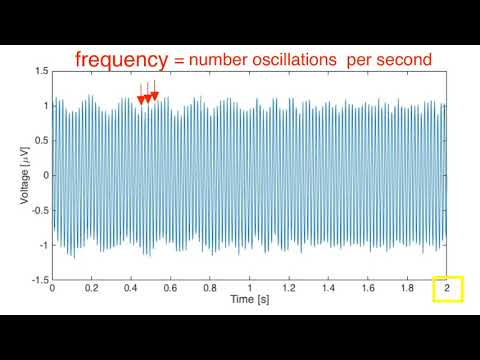

In [8]:
YouTubeVideo('GepHsNVXTN4')
# NO CODE

You might notice, through visual inspection, a dominant rhythmic activity. We can approximate the frequency of this rhythm by counting the number of oscillations that occur in a 1 s interval. To do so, we might count the total number of maxima and divide by 2 (because we observe 2 seconds of data). However, counting so many maxima over an extended time interval is quite an error-prone procedure. Instead, let us count the number of maxima in the first 0.2 s, and then multiply by five; that will approximate the total number of peaks in a 1 s interval. We count about 12 peaks in the first 0.2 s, which corresponds to approximately 60 peaks in 1 s. That’s (approximately) 60 cycles per second or 60 Hertz (Hz).

<div class="question">
    
**Q.** What if you counted the minima, instead of the maxima? Do you get the same answer? What if you counted the zero crossings?
    
</div>

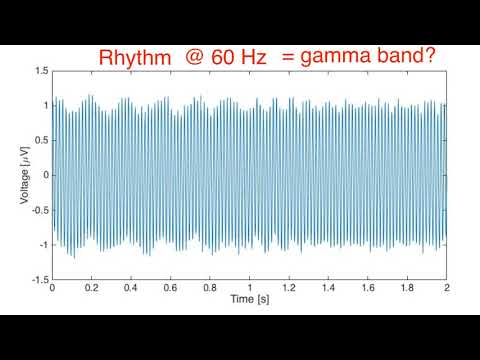

In [9]:
YouTubeVideo('mZ1uHN4lcPY')
# NO CODE

Visual inspection suggests a dominant rhythmic activity at a frequency of 60 Hz. With excitement we recall that high frequency oscillations in the 40-80 Hz band (the “[gamma band](https://en.wikipedia.org/wiki/Gamma_wave)”) are thought important for cognitive processing in the brain [[Nikolić, Fries, & Singer, 2013](https://doi.org/10.1016/j.tics.2012.12.003)]. But, there’s a reason for the label gamma band: the rhythmic activity observed *in vivo* is typically diffuse, spread over a range of rhythms at neighboring frequencies. The rhythmic activity observed here is concentrated and remarkably regular for EEG data.

<div class="warning">
    
**Important fact:** The alternating current in any North American electrical socket alternates at 60 Hz.
    
</div>

We conclude that the data are dominated by electrical noise and continue with additional analysis, beyond visual inspection of the time series data. Our visual inspection suggests a dominant 60 Hz signal, but perhaps something else is there, lurking in the signal background.

Sometimes visual inspection is enough, especially when something has gone wrong (e.g., if the EEG trace were zero for all time, we should be suspicious). But, looks can be deceiving. For one, the voltage trace is plotted as a continuous line, but that’s incorrect. If we look more closely, we find that the data consists of discrete points.

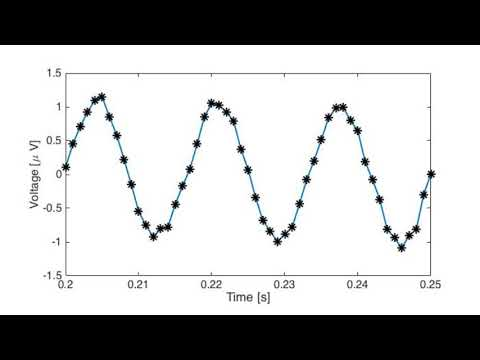

In [10]:
YouTubeVideo('UVnpQVUqpWI')
# NO CODE

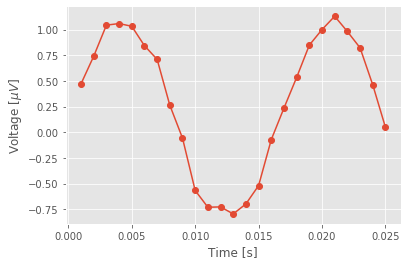

In [11]:
plot(t[:25], EEG[:25], 'o-')    # Plot the first 25 points of data,
xlabel('Time [s]')              # ... with axes labeled.
ylabel('Voltage [$\mu V$]')
show()

Although the true brain signal may evolve as a continuous voltage trace in time, we do not observe this true signal. Instead, we observe a discrete sampling of this signal in time. The spacing between these samples is determined by the recording device collecting the EEG data. In this case, our collaborator has told us that the data are sampled at 1000 Hz, which corresponds to a sample of data every 1 ms. So, we observe not the (presumably) continuous true voltage signal, but instead discrete samples of this signal in time.

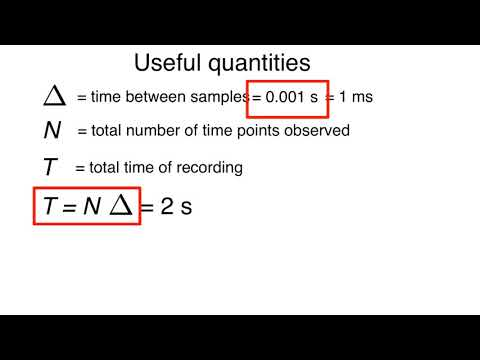

In [12]:
YouTubeVideo('W9BTYZM8yzs')
# NO CODE

To understand the impact of this discrete sampling, we first require some definitions. Let’s define $\Delta$ as the time between samples, in this case, $\Delta = 1$ ms. We also define $N$ as the total number of points observed, and $T$ as the total time of the recording. These three terms are related:

$T = N \Delta$.

For the $T = 2$ s of EEG data, there are $N = T/dt = 2/0.001 = 2000$ points. From this, we can also define the **sampling frequency**

$f_0 = 1/\Delta$

which in this case is 1000 Hz. Finally, we define a symbol for the data, $x$, which we also write as $x_n$ to explicitly indicate the index $n \in \{1, 2, 3, \ldots, N\}$ corresponding to the sample number. Let’s also define all of these variables in Python:

In [13]:
x = EEG           # Relabel the data variable
dt = t[1] - t[0]  # Define the sampling interval
N = x.shape[0]    # Define the total number of data points
T = N * dt        # Define the total duration of the data

We will need to keep the sampling interval $\Delta$ and the total recording duration $T$ in mind&mdash;both will serve fundamental roles in our characterization of the rhythmic activity.

<div class="question">
    
**Q.** In the second line of the code above we define the sampling interval as `dt = t[1] - t[0]`. How else could we have defined `dt`? Would `t[10] - t[9]` be appropriate?
    
</div>

[Return to top](#top)

### Step 2: Mean, variance, and standard deviation<a id="mean"></a>

As a first step in our analysis of the EEG data, let’s define two of the simplest measures we can use to characterize data $x$: the mean and variance <sup><abbr title="We could instead write the sample mean, because we use the observed data to estimate the theoretical mean that we would see if we were to keep repeating this experiment. This distinction is not essential to our goals here, but is important when talking to your statistics-minded colleagues. Throughout this chapter and others, we omit the term “sample” when referring to sample means, variances, covariances, and so forth, unless this distinction becomes essential to our discussion.">*note*</abbr></sup>. To estimate the mean $\bar x$, or average value, of $x$ we compute,

<p title="Mean">
$$ \bar x = \frac{1}{N}\sum_{n=1}^N x_n. $$
</p>

In words, we sum the values of $x$ for all $n$ time indices, then divide by the total number of points summed ($N$). To estimate the variance $\sigma^2$ of $x$ we compute,

<p title="Variance">
$$ \sigma^2 = \frac{1}{N}\sum_{n=1}^N (x_n - \overline x)^2,$$
</p>

which characterizes the extent of fluctuations about the mean. The *standard deviation* is simply the square root of the variance (i.e., $\sigma$). It's straightforward to compute all three quantities on an `ndarray` in Python:

In [14]:
mn = x.mean()  # Compute the mean of the data
vr = x.var()   # Compute the variance of the data
sd = x.std()   # Compute the standard deviation of the data

print('mn = ' + str(mn))
print('vr = ' + str(vr))
print('sd = ' + str(sd))

mn = 2.731148640577885e-17
vr = 0.5047172407856452
sd = 0.7104345436320261


<div class="python-note">
    
**A note on data types:** As used above, `mean()`, `var()`, and `std()` are methods of a type of variable called an *ndarray* (use `type(x)` to see what type of variable `x` is). The SciPy `loadmat()` function automatically imports variables to this data type, but it is likely that you will end up working with other data types as well. If you find that `x.mean()` produces an error, `x` is probably not an ndarray. In this case, you should import the `numpy` module and either convert your variable to an ndarray using `numpy.array(x)`, or calculate the mean using `numpy.mean(x)`.
    
</div>

<div class="question">
    
**Q.** Compare the mean computed above with the plot of the EEG data. Are the two consistent? How does the standard deviation compare with the EEG fluctuations in the plot?

**A.** The computed mean is approximately 0. Visual inspection of the plot suggests that the EEG data fluctuate around a center value of 0, so the computed mean is consistent with our visual inspection of the data. The computed standard deviation is approximately 0.71. We expect that most of the signal fluctuations lie within two standard deviations (i.e., $\pm 2\sigma$) of the mean. We therefore expect to observe EEG values mostly between 0 ± 1.4 = (−1.4, 1.4), which is in fact what we observe.
    
</div>

The mean and variance (and standard deviation) provide single numbers that summarize the EEG trace. In this case, these numbers are not particularly useful. Both may depend on many factors, including the electrical contact between the electrode and scalp surface, and the cognitive state of the subject. Here, we’re more interested in how the EEG activity is distributed across rhythms. We’ve already begun to assess rhythms in the EEG data through visual inspection of the time series. To further characterize these rhythms, we will employ another powerful tool - the Fourier transform. However, before introducing the Fourier transform, we’ll first consider an intimately related measure: the autocovariance.

[Return to top](#top)

### Step 3: The autocovariance<a id="autocovariance"></a>

Our visual inspection strongly suggests a prominent feature in the data&mdash;rhythmic activity. Rhythmic activity represents a type of dependent structure in the data. For example, if we know the data tends to oscillate near 60 Hz, then given the value of the EEG data now, we can accurately predict the value of the EEG data 1/60 s in the future (i.e., one cycle of the 60 Hz activity); it should
be similar. One technique to assess the dependent structure in the data is the autocovariance. To start, let’s write down the formula for the autocovariance, $r_{xx}[L]$, evaluated at lag $L$,

<a id="eq:3.3"></a>
$$r_{xx}[L] = \frac{1}{N}\sum_{n=1}^{N-L}(x_{n+L} - \bar x)(x_n - \bar x).$$

In words, the autocovariance multiplies the data $x$ at index $n + L$, by the data $x$ at index $n$, and sums these products over all indices $n$. Notice that, in both terms, the mean value $\bar x$ is subtracted from $x$ before computing the product, and we divide the resulting sum by the total number of data points in $x$. We note that this is a *biased* estimate of the autocovariance; we compare this to an unbiased estimate of the autocovariance in the supplement entitled [*Biased versus unbiased autocovariance*](https://eschlaf2.github.io/Case-Studies-Python/03/supplement-autocovariance.html).

To gain some intuition for the autocovariance, let’s represent $x$ graphically as a one-dimensional row vector. 

![cartoon of a row vector](imgs/3-3a.png "We imagine the data x as a one-dimensional vector with indices n = {1,2,3,...N}.")

For the case $L = 0$, the autocovariance is simply the element-by-element product of x with itself, summed over all indices.

![autocovariance at lag 0](imgs/3-3b.png "The autocovariance at lag 0. To compute the autocovariance, we sum the multiplied elements, and then divide by N (the total number of data points).")

For the case $L = 1$, we shift $x$ by one index, multiply element-by-element the original (unshifted) $x$ by the shifted version, and sum over all indices.

![autocovariance at lag 1](imgs/3-3c.png "The autocovariance at lag 1. To compute the autocovariance, we sum the multiplied elements and then divide by N (the total number of data points). Gray index labels at the beginning and end of each vector indicated data points not involved in computing the autocovariance at the chosen lag L.")

This process of shifting, element-by-element multiplying, and summing can be repeated for both positive and negative values of the lag $L$. Notice that, for larger values of $L$, we lose values at the beginning and ends of the autocovariance.

![autocovariance at lag 2](imgs/3-3d.png "The autocovariance at lag 2. To compute the autocovariance, we sum the multiplied elements and then divide by N (the total number of data points). Gray index labels at the beginning and end of each vector indicated data points not involved in computing the autocovariance at the chosen lag L.")

<div class="question">
    
**Q.** What is the largest reasonable value of $L$ to consider? For example, does a value of $L$ greater than $N$ make sense?
    
</div>

The autocovariance will be largest at the lag $L$ for which the values of x "match". For most functions, the autocovariance is largest at $L = 0$ (of course $x$ matches itself with zero shift) and tends to decrease as the magnitude of $L$ increases. Physically, the decrease in autocovariance with lag is consistent with the notion that data becomes less similar as time progresses. For example, in an EEG recording, we expect the activity now to be similar to the activity in the immediate future, but different from the EEG activity in the more distant future; as the brain responds to different internal and external cues, we expect different EEG activities to emerge, and associations between the EEG activity now and later to decay. Functions $x$ that exhibit dependent structure possess informative features in the autocovariance, as we’ll see for the EEG data in a moment.

<div class="question">
    
**Q.** Compare the [autocovariance](#autocovariance) at $L=0$ and the [standard deviation](#mean). Notice anything similar?
    
</div>

To compute the autocovariance of the EEG data, we execute the following commands<a id="fig:3-4a"></a>

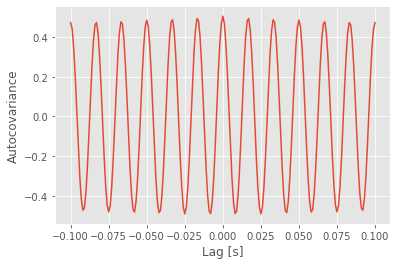

In [15]:
import numpy as np
lags = np.arange(-len(x) + 1, len(x)) # Compute the lags for the full autocovariance vector
                                      # ... and the autocov for L +/- 100 indices
ac = 1 / N * np.correlate(x - x.mean(), x - x.mean(), mode='full')
inds = abs(lags) <= 100            # Find the lags that are within 100 time steps
plot(lags[inds] * dt, ac[inds])       # ... and plot them
xlabel('Lag [s]')                     # ... with axes labelled
ylabel('Autocovariance')
savefig('imgs/3-4a')
show()

<div class="question">
    
**Q.** Examine the plot of the autocovariance of the EEG data. What do you observe?
    
</div>

Notice that the first input to the function `correlate` is the EEG data with the mean subtracted (`x - mean(x)`). One striking feature of the autocovariance is the periodicity. A careful inspection shows that the autocovariance exhibits repeated peaks and troughs approximately every 0.0166 s.

<div class="question">
    
**Q.** Why does the autocovariance exhibit repeated peaks and troughs approximately every 0.0166 s?

**A.** The autocovariance is reflective of the dominant rhythmic activity in the data. Remember that the EEG data are dominated by a 60 Hz rhythm.
    
</div>

To gain intuition for how this rhythmic activity affects the autocovariance, we can also plot examples of the EEG data **aligned with different lags** $L$. We'll do so below in Python by examining different shifts of the 60 Hz cycle.

Let's start by considering the case of $L=0$.

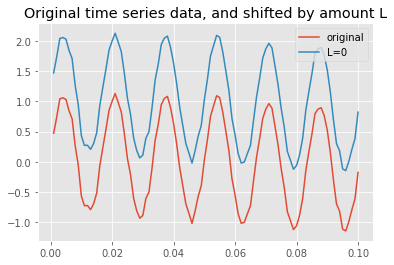

In [16]:
inds = range(100)                   # Choose a subset of the data to plot
plot(t[inds], x[inds], label="original");   # Plot the original
L=0;                                # Choose the lag,
                                    # ... and plot the shifted traces.
plot(t[inds], x[[i + L for i in inds]] + 1, label="L={}".format(L))
legend()                        # Add a legend and informative title
title("Original time series data, and shifted by amount L");

At zero lag ($L = 0$), the two time series are identical. Therefore, the product

$$(x_{n+0} - \bar x)(x_n - \bar x) = (x_n - \bar x)(x_n - \bar x) = (x_n - \bar x)^2$$

is non-negative for all indices $n$ (note that the product may sometimes be zero, but it’s never negative). To compute the autocovariance, we sum this product over all indices $n$, and divide by $N$, as defined in the equation for the autocovariance,

$$r_{xx}[L] = \frac{1}{N}\sum_{n=1}^{N-L}(x_{n+L} - \bar x)(x_n - \bar x).$$

Because we sum many positive terms, we expect to find a large positive value for $r_{xx}[0]$. And indeed, that's what we find; let's print the value of the autocovariance at lag 0:

In [17]:
ac[where(lags == 0)]

array([0.50471724])

Let's now consider shifting the EEG data by **an integer multiple** of the 60 Hz cycle. Let's use a particular integer multiple of 2:

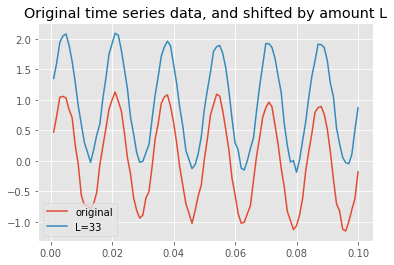

In [18]:
plot(t[inds], x[inds], label="original");       # Plot the original
L=int(2*1/60/dt);                               # Choose the lag,
                                                # ... and plot the shifted traces.
plot(t[inds], x[[i + L for i in inds]] + 1, label="L={}".format(L))
legend()                                    # Add a legend and informative title
title("Original time series data, and shifted by amount L");

Therefore, at this lag $L$, we again expect the summed product

$$(x_{n+L} - \bar x)(x_n - \bar x)$$

over all indices $n$ to be large, and to find a large positive value for $r_{xx}[L]$. To see  that's what we find let's print the value of the autocovariance at lag 34:

In [19]:
ac[where(lags == L)]

array([0.48702814])

Notice that this value is positive, and near the value of the autocorrelation at lag 0. In fact, we expect the autocovariance to be large and positive whenever the lag $L$ is an integer multiple of the 60 Hz cycle (i.e., an integer multiple of 1/60 ≈ 0.0166 s); this is exactly what we find in the [plot of the autocovariance](#fig:3-4a).<span class="sup">fig<img src="imgs/3-4a.png"></span>

Finally, let's shift the EEG data by **half** of the 60 Hz cycle.

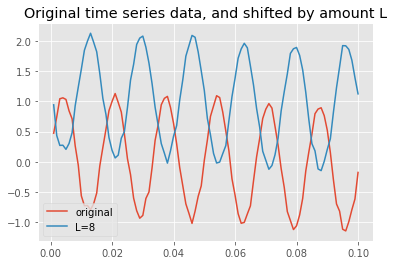

In [20]:
plot(t[inds], x[inds], label="original");       # Plot the original
L=int(1/2*1/60/dt);                             # Choose the lag,
                                                # ... and plot the shifted traces.
plot(t[inds], x[[i + L for i in inds]] + 1, label="L={}".format(L))
plt.legend()                                    # Add a legend and informative title
plt.title("Original time series data, and shifted by amount L");

We observe a different type of relationship; at this lag, let’s call it $L^∗$, positive values in the unshifted EEG correspond to negative values in the shifted EEG. Therefore, most terms in the product

$$(x_{n + L^*} - \bar x)(x_n - \bar x)$$

are negative, and summing up these terms to compute the autocovariance we find a large **negative** value for $r_{xx}[L^*]$. To see that, let's print the value of the autocovariance at lag 8:

In [21]:
ac[where(lags == 8)]

array([-0.49007471])

Finally, let's plot the autocovariance again, highlighting the lags we investigated above, at different shifts in the 60 Hz cycle

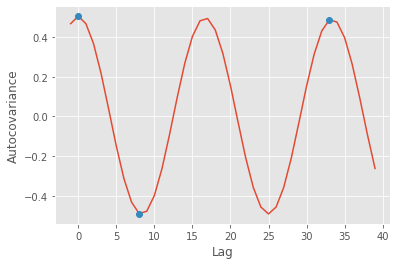

In [22]:
# Plot the autocovariance again, highlighting lags at 3 different shifts in the 60 Hz cycle
inds = [l in range(-1, 40) for l in lags]        # Get the lags in a limited range
plot(lags[inds], ac[inds])                       # ... and plot the autocovariance,
L = [0, 33, 8]                                   # Consider three specific lags
plot(sorted(L), ac[[l in L for l in lags]], 'o') # ... and highlight them
xlabel('Lag')                                    # Label the axes.
ylabel('Autocovariance');

The autocovariance is a useful tool for assessing the dependent structure in the EEG data. Visual inspection of the EEG reveals a specific type of dependent structure - a strong rhythmic component - in the data. This dependent structure is further characterized in the autocovariance, in which the dominant 60 Hz activity manifests as periodic peaks and troughs in the autocovariance. In the next section, we consider a second tool - the spectrum - for assessing dependent structure in time series data. As we’ll see, the autocovariance and spectrum are intimately related in a remarkable way.

[Return to top](#top)

### Step 4: Power spectral density, or spectrum<a id="power-spectral-density"></a>

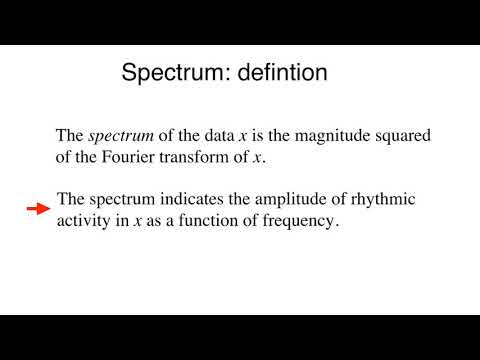

In [23]:
YouTubeVideo('OAHpkZy6ZX8')
# NO CODE

There are many techniques to assess rhythmic activity in the EEG data. Here, we compute the *power spectral density*, or simply the *spectrum*, of $x$ using a well-established technique, the [*Fourier transform*](https://en.wikipedia.org/wiki/Fourier_transform). There are many subtleties associated with computing and interpreting the spectrum. We explore some of them here; in doing so, we build our intuition for spectral analysis and our ability to deal with future, unforeseen circumstances in other data we encounter in research.

<div class="math-note">
    
The *spectrum* of the data $x$ is the magnitude squared of the Fourier transform of $x$. The spectrum indicates the amplitude of rhythmic activity in $x$ as a function of frequency.

The *power spectral density* describes the extent to which sinusoids of a single frequency capture the structure of the data. To compute the power over any range of frequencies, we would integrate (or for discrete frequencies, sum) the spectrum over that frequency range.

    
</div>

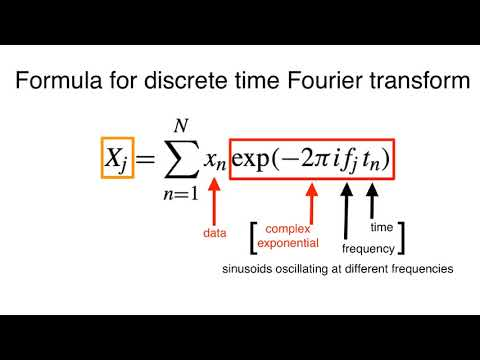

In [24]:
YouTubeVideo('iPUpMS79xgo')
# NO CODE

<a id="spectrum"></a>
**Computing the spectrum.** We start by presenting all the formulas and code necessary to compute the spectrum of the data. Then throughout the rest of this module, we circle back and consider each step of the computation in detail.

We first need a formula for the discrete-time Fourier transform of the data x:<a id="eq:3.8"></a>

$$X_j = \sum_{n=1}^N x_n \exp(-2 \pi i f_j t_n).$$

The Fourier transform computes the sum over all the time indices $t_n = \Delta\{1, 2, 3, ..., N\}$ of the data $x_n$ multiplied by sinusoids oscillating at a given frequency $f_j = j / T$, where $j = \{N/2 + 1, -N/2 + 2, ..., N/2 - 1, N/2\}$. The result is a new quantity $X_j$, the signal as a function of frequency $f_j$ rather than time $t_n$. The spectrum is then <a id="eq:3.9"></a>

$$S_{xx, j} = \frac{2\Delta^2}{T}X_j X_j^*,$$

which is the product of the Fourier transfrom of $x$ with its complex conjugate (indicated by the superscript $*$), scaled by the sampling interval and the total duration of the recording. The term $2\Delta^2/T$ is simply a numerical scaling. The units of the spectrum are, in this case, ($\mu$V)$^2/$Hz. Computing the spectrum in Python requires only a few lines of code:<a id="fig:3.6"></a>

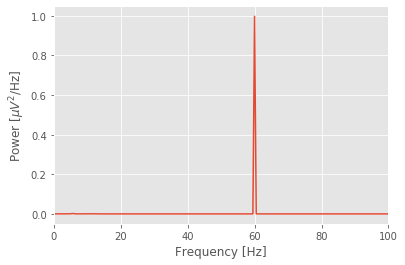

In [25]:
xf = fft(x - x.mean())               # Compute Fourier transform of x
Sxx = 2 * dt ** 2 / T * (xf * np.conj(xf))  # Compute spectrum
Sxx = Sxx[:int(len(x) / 2)]                 # Ignore negative frequencies

df = 1 / T.max()                            # Determine frequency resolution
fNQ = 1 / dt / 2                            # Determine Nyquist frequency
faxis = np.arange(0,fNQ,df)                 # Construct frequency axis

plt.plot(faxis, np.real(Sxx))               # Plot spectrum vs frequency
plt.xlim([0, 100])                          # Select frequency range
xlabel('Frequency [Hz]')                    # Label the axes
ylabel('Power [$\mu V^2$/Hz]')
plt.show()

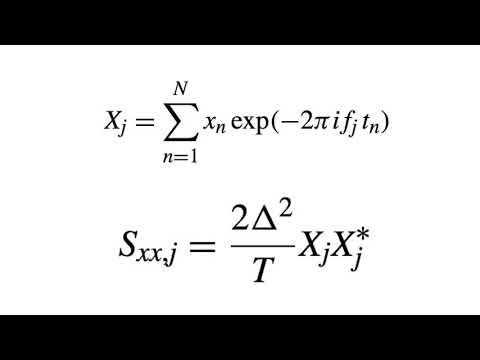

In [26]:
YouTubeVideo('kmHCCzAbMVI')
# NO CODE

That’s not so bad; the code to compute and display the spectrum fits in 13 lines (with spacing for aesthetics). Notice the large peak at 60 Hz. This peak is consistent with our visual inspection of the EEG data, in which we approximated a dominant rhythm at 60 Hz by counting the number of peaks that appeared in the voltage traces. So, our computation of the spectrum at least matches our initial expectation deduced from visual inspection of the data.

We’ve managed to compute and plot the spectrum, and our analysis results match our expectations. We could choose to stop here. But a danger persists: we’ve blindly entered Python code and achieved an expected result. What are the frequency resolution and Nyquist frequency mentioned in the comments of the code? Maybe this procedure is fraught with pitfalls, and we simply got lucky in this case? Does the spectrum provide additional information that was not immediately uncovered? How will we react and adapt when the spectrum results do not match our intuition? To answer these questions requires developing more intuition for the Fourier transform and spectrum. 

In a [supplement to this chapter](supplements), we examine equations for the Fourier transform <a href="#eq:3.8" class="thumb"><span><img src="imgs/eq3-8.png"></span></a> and spectrum <a href="#eq:3.9" class="thumb"><span><img src="imgs/eq3-9.png"></span></a> and the Python code for computing these quantities. In doing so, we explore some subtleties of this measure and strengthen our intuition for this measure’s behavior. Building this intuition is perhaps the most important part of dealing with unforeseen circumstances arising in your own data. If this is your first time thinking about the spectrum or Fourier transform, we recommend that you take a moment to read the supplement.

### Discrete Fourier Transform in Python <a id="dft"></a>

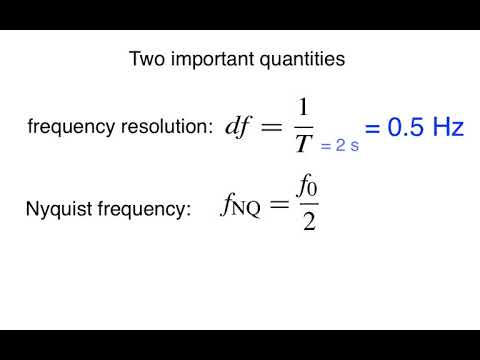

In [27]:
YouTubeVideo('noCOC69jvh8')
# NO CODE

Computing the spectrum of a signal $x$ in Python can be achieved in two simple steps. The first step is to compute the Fourier transform of $x$:

In [28]:
x = EEG
xf = rfft(x - x.mean()).real
             

We subtract the mean from `x` before computing the Fourier transform. This is not necessary but often useful. For these neural data, we’re not interested in the very slow (0 Hz) activity; instead, we’re interested in rhythmic activity. By subtracting the mean, we eliminate this low-frequency activity from the subsequent analysis.

The second step is to compute the spectrum, the Fourier transform of $x$ multiplied by its complex conjugate:<a id="fig:3.10"></a>

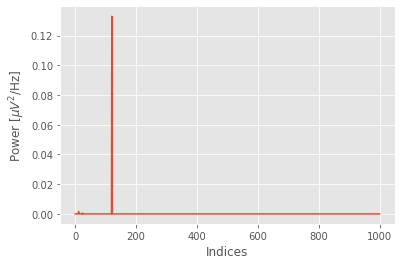

In [29]:
Sxx = 2 * dt ** 2 / T * xf * xf.conj()
plot(Sxx)
xlabel('Indices')
ylabel('Power [$\mu V^2$/Hz]');

Upon examining the horizontal axis in this plot, we find it corresponds to the indices of `x`, beginning at index 0 and ending at index `N = 1000`. To convert the x-axis from indices to frequencies, we need to define two new quantities:

* the **frequency resolution**, $df = \frac{1}{T}$, or the reciprocal of the total recording duration;
* the **Nyquist frequency**, $f_{NQ} = \frac{f_0}{2} = \frac{1}{2\Delta}$, or half of the sampling frequency $f_0 = \frac{1}{\Delta}$.

For the clinical EEG data considered here, the total recording duration is 2 s ($T = 2$ s), so the frequency resolution

$$df = 1 / (2\ s) = 0.5\ Hz.$$

The sampling frequency $f_0$ is 1000 Hz, so

$$f_{NQ} = 1000 / 2\ Hz = 500\ Hz.$$

There's much more to say about both quantities, but for now let's simply use both quantities to consider how Python relates the indices and frequencies of the vector `Sxx`.

<div class="python-note">
    
When we used the `rfft` function we utilized a useful property of the Fourier transform. If instead of using `rfft` we had used `fft`, we would see that the vector `Sxx` is twice as long because the Fourier transform also calculates the spectrum for the negative frequencies. However, when a signal is real (i.e., the signal has zero imaginary component), the negative frequencies in the spectrum are redundant. So, the power we observe at frequency $f$ is identical to the power we observe at frequency $-f$. For this reason, we can safely ignore the negative frequencies; these frequencies provide no additional information. Because the EEG data are real, we conclude that the negative frequencies in the variable `Sxx` are redundant and can be ignored. As a specific example, the value of `Sxx` at index $j = 2$ is the same as the value of `Sxx` at index $j = 2N - 2$; these indices correspond to frequencies $2df$ and  $-2df$, respectively. We therefore need only plot the variable `Sxx` for the positive frequencies, more specifically, from index `0` to index `N`. 

    
</div>

Given the total duration of the recording ($T$) and the sampling frequency ($f_0$) for the data, we can define the frequency axis for the spectrum `Sxx`. Now, to compute and plot the spectrum, we again utilize some code introduced earlier:

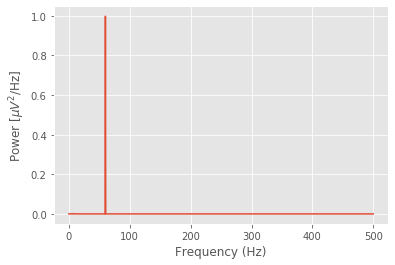

In [30]:
xf = rfft(x - x.mean())
Sxx = (2 * dt ** 2 / T * ( xf * xf.conj() ) ).real
df = 1 / T
fNQ = 1 / dt / 2
faxis = np.arange(len(Sxx)) * df
plot(faxis, Sxx)
xlabel('Frequency (Hz)')
ylabel('Power [$\mu V^2$/Hz]')
show()

In the next two sections, we focus on interpreting and adjusting the quantities $df$ and $f_{NQ}$. Doing so is critical to developing a further intuition for the spectrum.

#### The Nyquist frequency, $f_{NQ}$ <a id="nyquist-frequency"></a>

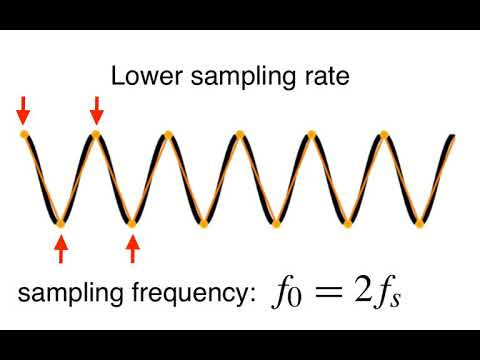

In [31]:
YouTubeVideo('sgYkOkrlQ_E')
# NO CODE

The formula for the Nyquist frequency is <a id="eq:3.13"></a>

$$f_{NQ} = \frac{f_0}{2}.$$

The Nyquist frequency is the highest frequency we can possibly hope to observe in the data. To illustrate this, let’s consider a true EEG signal that consists of a very simple time series—a pure sinusoid that oscillates at some frequency $f_s$. Of course, we never observe the true signal. Instead, we observe a sampling of this signal, which depends on the sampling interval $\Delta$. We consider three cases for different values of $\Delta$. In the first case, we purchase a very expensive piece of equipment that can sample the true signal at a high rate, $f_0 \gg f_s$. In this case, we cover the true brain signal with many samples and given these samples, we can accurately reconstruct the underlying data.

<a id="fig:3.11top"><img src="imgs/3-11top.png" title="A sinusoid oscillating below the Nyquist frequency. When the sampling rate is high enough, the sampled data provide a good approximation to the true data. Here, the sampling frequency is 8 times the oscillation frequency (i.e. the sinusoid is sampled eight times in each oscillation of the function)." alt="Sampling a sinusoid at a high rate."></a>

Now, consider the case in which we purchase a cheaper piece of equipment that samples at a maximum rate equivalent to twice the frequency of the pure sinusoid: $f_0 = 2f_s$. In this case, we might collect sufficient samples to cover the underlying signal and approximate the oscillation frequency; if the first sample resides on a peak of the sinusoid, the next sample on a trough, and so on.

<a id="fig:3.11mid"><img src="imgs/3-11mid.png" title="A sinusoid oscillating at the Nyquist frequency. In this case we collect two samples per cycle of the underlying true signal." alt="Sampling a sinusoid at double the oscillation frequency."></a>

In this case, we collect two samples per cycle of the underlying true signal. Given only these sample points, we can connect the dots and still approximate the frequency fo the true underlying sinusoid.

<div class="question">
    
**Q.** For the sampling rate $f_0 = 2f_s$, consider the case in which the first sample occurs on a zero crossing of the sinusoid. At what point does the next sample occur? and the next sample? If you connect the dots in this case, what do you find?
    
</div>

Finally, consider the case where our equipment records at a sampling rate less than the frequency of the pure sinusoid signal: $f_0 < 2 f_s$. 

<a id="fig:3.11bot"><img src="imgs/3-11bot.png" title="A sinusoid oscillating above the Nyquist frequency. When the sampling rate is too low, the true high-frequency signal appears as a low-frequency oscillation." alt="Sampling a sinusoid at less than double the oscillation frequency."></a>

Assuming the first sample occurs at a peak of the sinusoid, the next sample occurs not at a trough (that would correspond to a sampling rate $f_0 = 2f_s$) but instead just after the trough. Connecting the samples with lines, in this case, produces something horrifying, an oscillation occurring at a different, lower frequency. Notice what has happened in this case. Sampling the sinusoid at too low a frequency (i.e., at a frequency less than twice the signal's frequency $f_0 < 2f_s$) causes this signal to manifest at a low-frequency upon sampling. This phenomenon—a high-frequency signal appearing as a low-frequency signal upon sampling&mdash;is known as *aliasing*. Once a signal has been aliased, it's impossible to distinguish from true signals oscillating at low frequencies.

<div class="math-note">
    
To avoid aliasing, sample data at sufficiently high rates.

</div>

Typically, to prevent aliasing, recorded data are first analog-filtered before the digital sampling occurs. The analog filtering guarantees that activity at frequencies exceeding a threshold value ($f_c$, say) are dramatically reduced. The sampling rate can then be chosen to exceed this threshold value by at least a factor of 2 (i.e., $f_0 > 2f_c$). We note that in this case the EEG data were first analog-filtered at 200 Hz before digital sampling occurred at 1000 Hz. So, for our EEG data, aliasing is not a concern.

###  The frequency resolution, $df$<a id="frequency-resolution"></a>

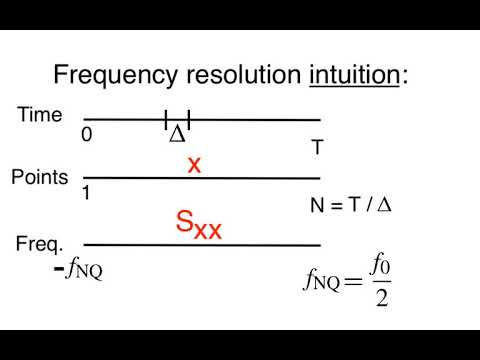

In [32]:
YouTubeVideo('bZsj_gcGoSo')
# NO CODE

The frequency resolution is defined as 

$$df = \frac{1}{T}$$

where $T$ is the total duration of the recording. For the EEG data used in this chapter, $T = 2$ s, so the frequency resolution is $df = 1/(2\ \mbox s) = 0.5$ Hz.

<div class="question">
    

**Q.** How do we improve the frequency resolution?


**A.** There’s only one way to do it: increase $T$. That is, record more data. For example, if we demand a frequency resolution of 0.2 Hz, how much data must we record? We can rearrange the equation to solve for $T$,
    
    $$T = \frac{1}{df} = \frac{1}{0.2\mbox{ Hz}} = 5\mbox{ s}$$
    
    
So, record 5 s of data to obtain a frequency resolution of 0.2 Hz. 
    

    
</div>

<div class="question">
    

**Q.** We estimated the spectrum in the preceding code. As we record more and more data, does the estimate of the spectrum improve?


**A.** Intuitively, you might answer yes. As we collect more and more data, we usually expect our estimate of a quantity (e.g., the mean or the standard deviation) to improve. However, that is not the case for the spectrum. As we collect more and more data, we acquire more and more points along the frequency axis (i.e., $df$ becomes smaller). However, our estimate of the power at each frequency does not improve ([Percival & Walden, 1993](https://doi.org/10.1017/CBO9780511622762)).

    
</div>

To gain some intuition for the frequency resolution formula, consider the case in which we collect $T$ seconds of data. If the sampling interval is $\Delta$, then we collect $N = T/\Delta$ data points; for example, for the EEG data of interest here, we collect $N = 2000$ data points. We know that the number of observations in the data equals the number of frequencies in the spectrum (where we now include negative frequencies); both the data vector `x` and the spectrum vector `Sxx` have length $N$. We also know that the maximum observable frequency in the spectrum, the Nyquist frequency, is fixed no matter how much data we collect. Recall that the Nyquist frequency depends only on the sampling interval: $f_{NQ} = 1/(2\Delta)$. Now, consider the case in which we increase $T$, or equivalently, increase $N$. As we collect more and more data, the maximum frequency remains fixed at the Nyquist frequency, while the length of the spectrum vector increases. We therefore need to fit more and more frequency values between 0 Hz and the Nyquist frequency as $N$ increases. 

<a id="fig:3.12"><img src="imgs/3-12.png" alt="Cartoon representation of the relation between data and frequency resolution."></a>

Above we plot a cartoon representation of the relation between data and frequency resolution. Data (left) consist of different numbers of samples ($N$). As $N$ increases, the number of values on the frequency axis increases (right), the maximal frequency $(f_{NQ})$ remains fixed, and the frequency resolution ($df$) decreases. Only non-negative frequencies are shown.
This observation provides some intuition for the relation between the amount of data recorded ($T$ or $N$) and the frequency resolution ($df$).

[Return to top](#top)

### Step 5: Decibel scaling<a id="decibel-scaling"></a>

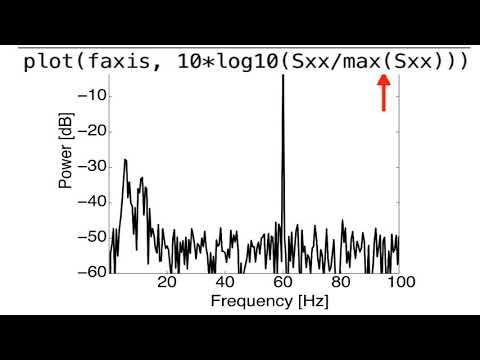

In [33]:
YouTubeVideo('SuDJha5LNL0')
# NO CODE

Let's now return to the [spectrum of the EEG data](#fig:3-6).
<span class="sup">fig<img src="imgs/3-6.png"></span>
We see that the spectrum is dominated by a single peak at 60 Hz. Other, weaker rhythmic activity may occur in the data, but these features remain hidden from visual inspection because of the large 60 Hz peak; informally, we might state that the 60 Hz peak saturates the vertical scale. One technique to emphasize lower-amplitude rhythms hidden by large-amplitude oscillations is to change the scale of the spectrum to **decibels**. The decibel is a logarithmic scale and easily computed as follows:
<a id="fig:3.13a"></a>

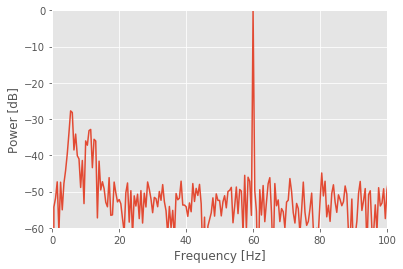

In [34]:
plot(faxis, 10 * np.log10(Sxx / max(Sxx)))   # Plot the spectrum in decibels.
xlim([0, 100])                           # Select the frequency range.
ylim([-60, 0])                           # Select the decibel range.
xlabel('Frequency [Hz]')                     # Label the axes.
ylabel('Power [dB]')
savefig('imgs/3-13a')
show()

To change to the decibel scale, we first divide the spectrum by the maximum value observed and then take the logarithm base 10 of this ratio and multiply the result by 10. The 60 Hz rhythm is still dominant and exhibits the most power.

<div class="question">
    

**Q.** For this example, what is the value in decibels at 60 Hz?



**A.** Through our previous analysis, we know that the maximum value in the spectrum occurs at 60 Hz. By dividing the original spectrum by this maximum, we scale the spectrum at 60 Hz to a value of 1. The logarithm of 1 is 0, so we find a value of 0 at 60 Hz. Note that all other values are now smaller than 1 and therefore negative on the decibel scale.

    
</div>

<div class="math-note">
    
Different conventions exist to define the decibel scale. Here we first divide by the maximum before computing the logarithm. Be sure to verify how the spectrum is scaled (if at all) to interpret the decibel axis.
    
</div>

The decibel scale reveals new structure in the spectrum. In particular, two peaks have emerged at frequencies 5–15 Hz. These peaks are much weaker than the 60 Hz signal; both peaks are approximately 30 dB below the maximum at 60 Hz, or equivalently, three *orders of magnitude* weaker. Because these peaks are so small relative to the 60 Hz signal, neither was apparent in the original plot of the spectrum.

To further emphasize the low-frequency structure of the spectrum, we may also convert the frequency axis to a logarithmic scale:

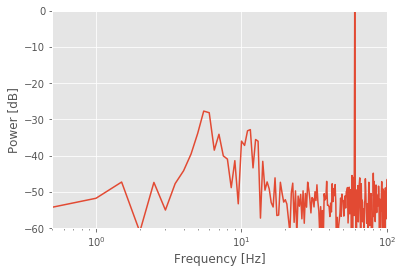

In [35]:
semilogx(faxis, 10 * np.log10(Sxx / max(Sxx)))   # Log-log scale
xlim([df, 100])                                  # Select frequency range
ylim([-60, 0])                                   # ... and the decibel range.
xlabel('Frequency [Hz]')                         # Label the axes.
ylabel('Power [dB]')
show()

Notice the change in the first line to use the `semilogx` function. By using the logarithmic scale to stretch the low-frequency part of the horizontal axis, the two low-frequency peaks become more apparent. The changes compared to the original spectrum are purely cosmetic. However, these cosmetic changes have proved extremely useful. The two lower-frequency peaks were originally hidden from us, both in visual inspection of the raw data and in the original plot of the spectrum. In those cases, the large-amplitude 60 Hz activity masked the smaller-amplitude (three orders of magnitude smaller) rhythms.

[Return to top](#top)

### Step 6: The spectrogram<a id="the-spectrogram"></a>

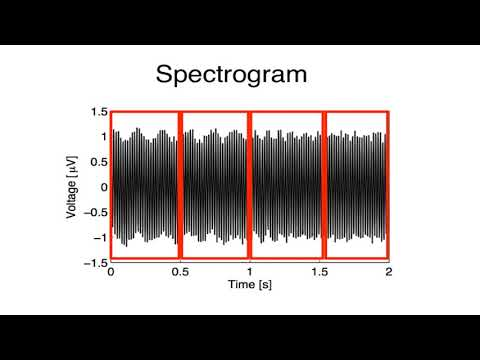

In [36]:
YouTubeVideo('XYy4NEr3VUs')
# NO CODE

The spectrum [plotted using the decibel scale](#fig:3.13a)<span class="sup">fig<img src="imgs/3-13a.png"></span> suggests that three rhythms appear in the EEG signal: 60 Hz, approximately 11 Hz, and approximately 6 Hz. Given only these results, we may reasonably conclude that these three rhythms appear simultaneously throughout the entire 2 s of the EEG recording. That is an assumption we make in computing the spectrum of the entire 2 s interval. To further test this assumption in the EEG data, we compute a final quantity: the *spectrogram*. The idea of the spectrogram is to break up the time series into smaller intervals of data and then compute the spectrum in each interval. These intervals can be quite small and can even overlap. The result is the spectrum as a function of frequency and time.

<div class="question">
    
**Q.** Consider the 2 s of EEG data. If we break up these data into smaller intervals of duration 1 s, what is the resulting frequency resolution of each interval? What is the Nyquist frequency of each interval? 
    
</div>

To compute and display the spectrogram in Python, we use the (aptly named) function `spectrogram` from the `scipy` module:<a id="fig:3.14"></a>

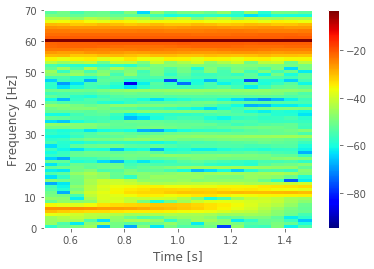

In [37]:
Fs = 1 / dt               # Define the sampling frequency,
interval = int(Fs)        # ... the interval size,
overlap = int(Fs * 0.95)  # ... and the overlap intervals

                          # Compute the spectrogram
f, t, Sxx = spectrogram(
    EEG,                  # Provide the signal,
    fs=Fs,                # ... the sampling frequency,
    nperseg=interval,     # ... the length of a segment,
    noverlap=overlap)     # ... the number of samples to overlap,
plt.pcolormesh(t, f, 10 * np.log10(Sxx),
               cmap='jet')# Plot the result
plt.colorbar()            # ... with a color bar,
ylim([0, 70])             # ... set the frequency range,
xlabel('Time [s]')       # ... and label the axes
ylabel('Frequency [Hz]')
savefig('imgs/3-14')
show()

We supplied four arguments to the `spectrogram` function. Briefly, these arguments specify the data, the sampling frequency, the interval size (specified in indices and here set to 1 s), and the overlap between intervals (here set to 95%). More information about these options can be found in the documentation (`signal.spectrogram?`). Notice that we used `int` to enforce integer values for three of these inputs.

<div class="python-note">
    
Note that in computing the spectrogram, we did not subtract the mean as we have done in the past. This is because the `spectrogram` function defaults to this behavior. 
    
</div>

<div class="question">    

**Q.** Consider the spectrogram above. What aspects of the spectrogram are consistent with our previous results? What aspects are new? Consider, in particular, the low-frequency rhythms and the conclusions deduced from this figure compared to the plot of the spectrum.<span class="sup">fig<img src="imgs/3-13a.png"></span>


**A.** The spectrogram displays the spectrum (in decibels) as a function of frequency (vertical axis) and time (horizontal axis). Values on the time axis indicate the center times of each 1 s window (e.g., 0.5 s corresponds to times [0, 1] s in the data). Intervals of high (low) values correspond to warm (cool) colors. Visual inspection immediately provides new insights into the observed EEG rhythms. First, we observe a band of high power at 60 Hz that persists for all time (yellow horizontal line in the plot of the spectrogram). This corresponds to the 60 Hz line noise present for the entire duration of the recording. Second, we observe intervals of increased power near 11 Hz and 6 Hz. Unlike the 60 Hz signal, the two low-frequency rhythms do not persist for the entire 2 s recording (as we may have incorrectly concluded from examination of the spectrum alone. Instead, one weak rhythm (near 6 Hz) appears for the first half of the recording, while another weak rhythm (near 11 Hz) appears for the second half of the recording. Visualization via the spectrogram of how the rhythmic activity changes in time allows this important conclusion.

    
</div>

[Return to top](#top)

# Summary <a id="summary"></a>

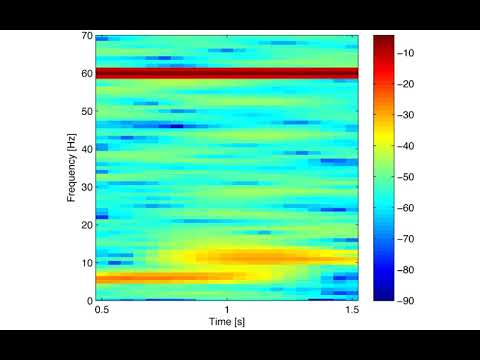

In [38]:
YouTubeVideo('jdceZRY_PDA')
# NO CODE

In this chapter, we analyzed 2 s of EEG data. We started with visual inspection of the [EEG time series](#fig:3.1).<span class="sup">fig<img src="imgs/3-1.png"></span> This is always the best place to start when analyzing new data and provides initial important intuition for the time series. Through the initial visual inspection, we concluded that rhythmic activity appeared and was dominated by a 60 Hz oscillation. Then, to characterize further the rhythmic activity, we computed two related quantities: the autocovariance and the spectrum. We found that rhythmic activity appeared in the autocovariance of the data. We then considered the spectrum. To do so, we first introduced the notion of the Fourier transform and discussed in detail how to compute the spectrum in Python. We also defined two fundamental quantities—the frequency resolution and the Nyquist frequency—and explored how to manipulate these quantities. (We recommend you commit both quantities to memory. For every spectral analysis you encounter, ask: What is the frequency resolution? What is the Nyquist frequency?). We then considered how [logarithmic scales](#fig:3.13a)  can be used to emphasize features of the spectrum.<span class="sup">fig<img src="imgs/3-13a.png"></span> And, we examined how the [spectrogram]("#fig:3.14") provides insight into spectral features that change in time.<span class="sup">fig<img src="imgs/3-14.png"></span> We concluded that the EEG data are dominated by 60 Hz activity throughout the 2 s interval, and that weaker low-frequency activity emerges during two intervals: a 6 Hz rhythm from 0 s to 1 s, and an 11 Hz rhythm from 1 s to 2 s.

In this module, we only touched the surface of spectral analysis; many details and issues exist for further exploration. In future modules, we will discuss the issues of windowing and zero padding. For those interested in exploring further, see [Percival & Walden, 1998](https://doi.org/10.1017/CBO9780511622762) and [Priestley, 1981](https://buprimo.hosted.exlibrisgroup.com/primo-explore/fulldisplay?docid=ALMA_BOSU121668583370001161&context=L&vid=BU&search_scope=default_scope&tab=default_tab&lang=en_US).

[Return to top](#top)

---

<a id="supplements"></a>
# Supplements

<a id="supplement-acv"></a>
## Biased versus unbiased autocovariance

Autocovariance is defined by the equation

<a id="eq:3.3"></a>
$$r_{xx}[L] = \frac{1}{N}\sum_{n=1}^{N-L}(x_{n+L} - \bar x)(x_n - \bar x).$$


This is a biased estimate of the true autocovariance. To compute an *unbiased* measure of the autocovariance we replace the $1/N$ term with $1/(N-L)$. 
    
$$r^*_{xx}[L] = \frac{1}{N - L}\sum_{n=1}^{N-L}(x_{n+L} - \bar x)(x_n - \bar x).$$


To examine the difference in the biased versus the unbiased autocovariance, let's compute both for the EEG data over a broad interval of lags.

In [39]:
# Import the data
data = loadmat('matfiles/EEG-1.mat')           # Load the EEG data.
x = data['EEG'].reshape(-1)               # Extract the EEG variable,
t = data['t'][0]                          # ... and the t variable.
N = len(x)                                # Get the total number of data points,
dt = t[1] - t[0]                          # ... and the sampling interval.

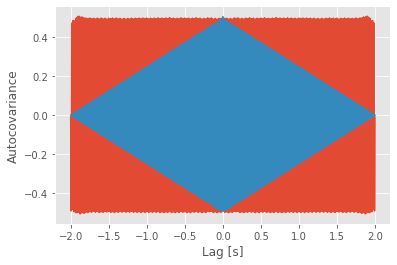

In [40]:
lags = arange(-N + 1, N)               # Compute the lags
                                          # Calculate non-normalized autocovariance
ac = correlate(x - x.mean(), x - x.mean(), mode="full")  
ac_b = 1 / N * ac                         # Calculate biased autocovariance
ac_u = 1 / (N - np.abs(lags)) * ac        # ... and unbiased autocovariance

fig, ax = subplots()                  # Plot the result and save the figure for later use
ax.plot(lags * dt, ac_u)                     # Plot the unbiased autocovariance,
ax.plot(lags * dt, ac_b)                     # ... and the biased,
xlabel('Lag [s]')                         # ... with axes labeled
ylabel('Autocovariance')
show()

We see the similarities and differences between these two estimates. At small lags (near 0 s), the biased and unbiased estimates of the autocovariance are similar. In this case, $L$ is small, so the factor 1/(N − L) in the unbiased estimate is similar to the factor of 1/N in the biased estimate. At large lags (away from 0 s), the biased and unbiased estimates of the autocovariance are quite different. Notice that, as L approaches ±2 s, the biased estimate (orange curve) approaches zero.

Compare this observation to the *unbiased* estimate of the autocovariance. In this example, we see that the unbiased estimate of the autocovariance remains large even as L approaches ± 2 (blue curve).

<div class="question">
    
**Q.** Why does the biased estimate of the autocovariance approach 0 at large lags? 

**A.** For concreteness, let's consider the case when $L = N - 2$. In this case, $L$ is large, and nearly equal to the number of points in the data ($N$). When $L$ is large, we shift the time series $x$ so that only a subset of indices overlap; the following is a cartoon representation of the $L = 2$ case:
![cartoon representation f L=2 autocovariance](imgs/3-3d.png)
Now consider the extension to $L=N-2$. Because we only compute the product

$$(x_{n+L} - \bar x)(x_n - \bar x)$$

for the overlapping indices of $x_n$ and $x_{n+L}$, we only include two terms in the  summation <a href="#eq:3.3" class="thumb"><span><img src="imgs/eq3-3.png"></span></a> The sum of these two terms is then divided by $N$, which results in a small number that approaches zero as L approaches N.
    
</div>

<div class="question">
    
**Q.** Why does the unbiased estimate of the autocovariance remain large at large lags? 

**A.** As in the biased case, let's again consider $L = N-2$. In this case, $L$ is large, and we shift the time series $x$ so that only a subset of indices overlap. Therefore, the product

$$(x_{n+L} - \bar x)(x_n - \bar x)$$

again only includes two terms in the autocovariance summation. However, in the unbiased case, the sum of these terms is divided by

$$N - L = N - (N - 2) = 2$$

Notice that as $L$ approaches $N$, the term $N - L$ approaches zero. In this case, we find a "balance" between the summation of two terms then a division by the number of terms in the sum (in this example, division by 2). This balance allows the unbiased estimate of the autocovariance to remain large as $L$ approaches $N$.

Careful inspection of the blue curve reveals another feature of the biased estimate; the estimated values at large lags become more variable (look carefully at lags near ±1.75 s and beyond). 

</div>

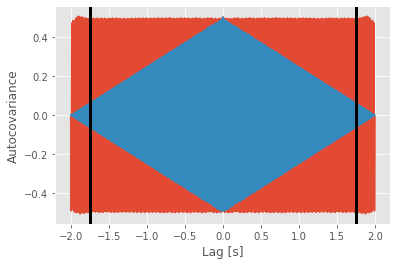

In [41]:
[ax.axvline(l, color='k', lw=3) for l in [-1.75, 1.75]]
fig
# NO CODE

<div class="question">

Increased variability at large lags occurs because, as $L$ approaches $N$, we have less data to compare in the assessment of the autocovariance. Notice that, when $L = N − 1$, the estimate of the autocovariance utilizes only two data points from $x$ (i.e., the product consists only of one term: $(x_N - \bar x)(x_1 - \bar x)$). We do not expect a reliable assessment of associations in the data with so few data points to compare.
    
</div>

With those observations, should we use the biased or unbiased estimator of the autocovariance? Statisticians typically prefer the biased estimator for a variety of reasons [[Percival & Walden, 1998]](https://doi.org/10.1017/CBO9780511622762). First, for many stationary processes, the mean squared error of the biased estimator is smaller than that of the unbiased estimator. The mean squared error depends on both the variance and bias of the estimator:

$$\mbox{mean squared error} = \mbox{variance + (bias)}^2.$$

Although the biased estimator is "biased", the variability of the unbiased estimator is more harmful. We saw a hint of this increased variability in the unbiased estimator at large lags. To make this observation more explicit, let's consider the lag $L = N - 1$, and compute the expression for the [biased estimator](#eq:3.3)<span class="sup">eq<img src="imgs/eq3-3.png"></span>,

<p title="Variance of the biased estimator with lag N-1">

\begin{eqnarray} 
r_{xx}[N-1] &=& \frac{1}{N} \sum_{n = 1}^{N - (N - 1)} (x_{n + (N - 1)} - \bar x)(x_n - \bar x),\\
&=&\frac{1}{N}\sum_{n=1}^1(x_{n+(N-1)} - \bar x)(x_n - \bar x), \\
&=&\frac{1}{N}(x_{N} - \bar x)(x_1 - \bar x).
\end{eqnarray}

</p>

The expression for the [unbiased estimator](#eq:3.3)<span class="sup">eq<img src="imgs/eq3-4.png"></span> becomes,

<p title="Variance of the unbiased estimator with lag N-1">
    
\begin{eqnarray}
r_{xx}^*[N-1] &=& \frac{1}{N - (N - 1)}\sum_{n=1}^{N - (N-1)}(x_{n+N-1} - \bar x)(x_n - \bar x), \\
&=& \sum_{n=1}^1(x_{n+N-1} - \bar x)(x_n - \bar x), \\
&=& (x_{N} - \bar x)(x_1 - \bar x), \\
\end{eqnarray}

</p>

These two expressions reveal that, at a large lag $L = N − 1$, the variance of the unbiased estimator is $N^2$ times the variance of the biased estimator. The dramatic increase in variance of the unbiased estimator leads to unreliable estimates of the autocovariance at large lags. Also, we note that the biased estimator behaves "nicely" as $L$ increases to $N$; we see from the expression for the biased estimator that $r_{xx}[N − 1]$ approaches 0 when $N$ is large. This is arguably the behavior we want; we have few data points to compare at large lags, and therefore an unreliable estimate of the autocovariance, so we’re better off disregarding these values. For these reasons, we’ll use the biased estimator; in this estimate, autocovariance values at large lags - which utilize less data and are typically noisier - are reduced.

We note that, for the EEG data of interest here, the unbiased estimator outperforms the biased estimator. For these data, which are dominated by a 60 Hz rhythm, there is significant autocovariance even at long lags. In this case, the biased estimator leads to an interpretation of decreasing autocovariance, even though that is not true. However, for most brain signal (not saturated by 60 Hz line noise), we expect the autocovariance to decrease in time.

[Return to top](#top)

---
<a id=supplement-psd></a>
## Intuition behind the power spectral density

* [The Fourier transform](#fourier-transform)
* [Relation to autocovariance](#autocovariance)
* [Relation to multiple linear regression](#multiple-linear-regression)

In [42]:
# Tools for this chapter
import statsmodels.formula.api as smf
from pandas import DataFrame as df
from scipy.io import loadmat

The main component of this module discusses the analysis of rhythmic activity. One important component of this analysis is the power spectral density. In this supplement, we examine equation for the Fourier transform

$$X_j = \sum_{n=1}^{N}x_n \exp(-2\pi i f_j t_n).$$

and the equation for the spectrum 

$$S_{xx, j} = \frac{2\Delta^2}{T}X_j X_j^*,$$

and the associated Python code. In doing so, we explore some subtleties of this measure and strengthen our intuition for this measure’s behavior. Building this intuition is perhaps the most important part of dealing with unforeseen circumstances arising in your own data.

<a id="fourier-transform"></a>
### What is the Fourier transform actually doing?

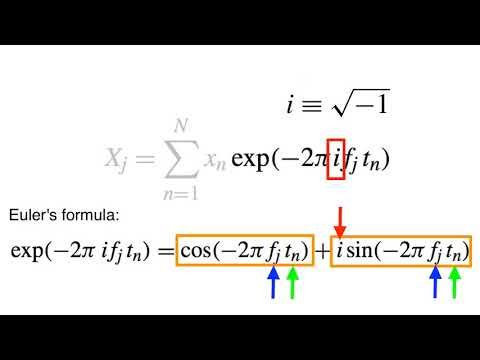

In [43]:
YouTubeVideo('TOszYv0pdKU')
# NO CODE

The Fourier transform represents the data $x$ as a linear combination of sinusoids with different frequencies. To see this, consider again:

$$X_j = \sum_{n=1}^{N}x_n \exp(-2\pi i f_j t_n).$$

What is this expression actually doing? Let's consider this equation piece by piece. The first term,

$$\sum_{n=1}^N$$

represents a sum over the indices of $x_n$. Because each subsequent index represents a step forward in time of $\Delta$, this sum represents a sum over time. In fact, this sum extends from the first index ($n=1$) to the last index ($n = N$) of the data, so the summation occurs over the entire duration of the recording. Adding the second term,

$$\sum_{n=1}^N x_n$$

the summation now acts on the data $x_n$, so we're summing up the data over all indices or equivalently over the entire time of recording. The third term, 

$$\exp(-2\pi i f_j t_n),$$

consists of an exponential ($\exp$) operating on the product of five individual terms, each of which is a number. The first two numbers are simple: $-2 \pi$. The third number is $i \equiv \sqrt{-1}$, a quantity representing an *imaginary unit*. The utility of the imaginary unit is that we can rewrite the exponential as the sum of a sine and cosine function. Remember from caclulus the remarkable [Euler's formula](https://en.wikipedia.org/wiki/Euler%27s_formula):

$$\exp(-2\pi i f_j t_n) = \cos(-2\pi f_j t_n) + i \sin(-2\pi f_j t_n).$$

Notice that the $i$ now appears multiplying the sine term, and not inside the arguments of either sinusoid. Both sinusoids operate on the product of $2\pi$ and two terms, the frequency $f_j$ and the time $t_n$. Rewriting the equation for the Fourier transform using Euler's formula, we find<a id="eq:3.10"></a>

\begin{equation}\tag{*}\label{eq:*}
X_j = \left(\sum_{n=1}^N x_n \cos(-2\pi f_j t_n) \right) + i\left(\sum_{n=1}^N x_n \sin(-2\pi f_j t_n)\right), 
\end{equation}

where the summation is distributed over both terms.

Written in this way, the Fourier transform becomes easier to interpret. Let’s consider the first term of the equation above. For each index $n$, we multiply the data $x_n$ by a cosine function evaluated at frequency $f_j$ and time $t_n$. We then sum the results of this multiplication over all indices from $n=1$ to $n=N$, or equivalently, from time $t_n = \Delta$ to time $t_n =T$. So, we multiply the data by a cosine function at frequency $f_j$ for each point in time and sum the product over time. The second term of the equation is like the first, except we multiply the data $x_n$ by a sine function.

We may therefore think of the Fourier transform as comparing the data $x$ to the sinusoids oscillating at frequency $f_j$. When the data and sinusoid at frequency $f_j$ align the summation in the Fourier transform is large and the result $X_j$ is a large number. When the data and sinusoid at frequency $f_j$ do not align, the summation in the Fourier transform is small and $X_j$ is a tiny number.

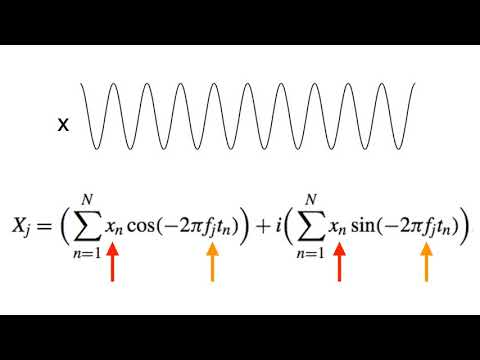

In [44]:
YouTubeVideo('PRoA5Zn_gbQ')
# NO CODE

To make these ideas more concrete, we can consider some simple examples. In these examples, the data $x$ will be a perfect cosine with frequency 10 Hz.

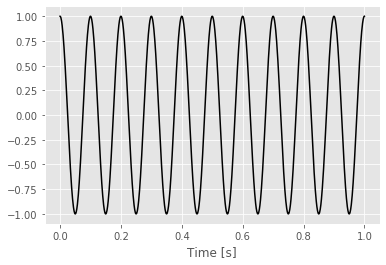

In [45]:
tt = np.linspace(0, 1, 1000)     # Create a time variable (in seconds)
x = np.cos(2 * np.pi * 10 * tt)  # Generate the data, a 10 Hz cosine
plot(tt, x, 'k')                 # Plot the result
xlabel('Time [s]')
show()

Choosing $f_j = 4$ Hz, we can construct a sine and cosine function each oscillating at 4 Hz.

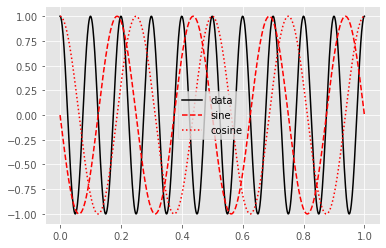

In [46]:
fj = 4                                 # Set frequency
fj_sin = np.sin(-2 * np.pi * fj * tt)  # construct sine wave
fj_cos = np.cos(-2 * np.pi * fj * tt)  # ... and cosine
plot(tt, x, 'k', label='data')         # Plot the data
plot(tt, fj_sin, 'r--', label='sine')  # ... and the sine
plot(tt, fj_cos, 'r:', label='cosine') # ... and cosine
plt.legend()
show()

Then, to perform the calculation of the Equation (*) we multiply the data $x$ by the sinusoids at each point in time.

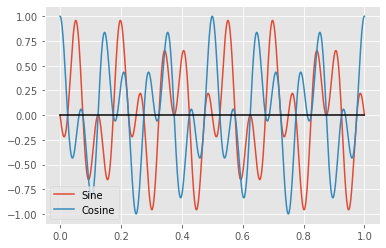

In [47]:
plot(tt, x * fj_sin, tt, x * fj_cos)  # Plot the product of x with the sinusoids
plt.legend(['Sine', 'Cosine'])
plot(tt, np.zeros_like(tt), 'k')      # Show zero
show()

Notice that the products alternate between positive and negative values throughout time. 

<div class="question">
    
**Q.** In this case, what is the approximate value of $X_j$ when $f_j = 4$ Hz?

**A.** We know that $X_j$ is the summation over time of the product of $x$ and the sinusoids,
    
\begin{equation}\tag{*}\label{eq:*}
X_j = \left(\sum_{n=1}^N x_n \cos(-2\pi f_j t_n) \right) + i\left(\sum_{n=1}^N x_n \sin(-2\pi f_j t_n)\right), 
\end{equation}
    
Above, we plotted these products over time. Because each product alternates between positive and negative values roughly equally over time, the summation of the product over time is approximately zero. We therefore conclude that both the real part (i.e., the cosine term) and the imaginary part (i.e. the sine term) are small and $X_j \approx 0 + 0i$ when $f_j = 4$ Hz. 
    
</div>

In this case, the sinusoids at frequency $f_j = 4$ Hz do not align with the data $x$, and $X_j$ is nearly zero in both its real and imaginary parts. Now consider the case in which we choose $f_j = 10$ Hz. With this choice of $f_j$, the data $x$ and the cosine function align perfectly.

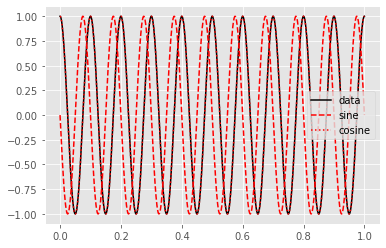

In [48]:
fj = 10                                # Set the frequency
fj_sin = np.sin(-2 * np.pi * fj * tt)  # Construct the sine wave
fj_cos = np.cos(-2 * np.pi * fj * tt)  # ... and cosine wave

plot(tt, x, 'k', label='data')         # Plot the data
plot(tt, fj_sin, 'r--', label='sine')  # ... and the sine
plot(tt, fj_cos, 'r:', label='cosine') # ... and cosine
plt.legend()
show()

<div class="question">
    
**Q.** Can you predict how the plot of the product of the data with the overlapping cosine function will look? Plot the product and check your prediction.
    
</div>

The product of the cosine function and the data is always non-negative, and therefore its summation over time results in a large positive number. In this case, the real part of $X_j$ is large because the cosine function with frequency $f_j =10$ Hz and the data $x$ match. In this sense, the Fourier transform reveals the dominant frequencies of the underlying time series.

<div class="question">
    
**Q.** What is the approximate value of the *imaginary* part of $X_j$ for $f_j = 10$ Hz? *Hint*: Consider the plot of the product of the sine function and the data.
    
</div>

<a id="autocovariance"></a>
### Relation of the spectrum to the autocovariance.
We’ve introduced two tools for assessing dependent structure in the EEG data: the autocovariance and the spectrum. Remarkably, these two measures are related in an important way.

<div class="alert alert-success">
    
The spectrum is the Fourier transform of the autocovariance.
    
</div>

The spectrum and autocovariance both assess dependent structure in the data but in different domains - the spectrum in the frequency domain and the autocovariance in the time domain. Notice that the spectrum $S_{xx, j}$ <a href="Analysis%20of%20rhythmic%20activity.ipynb#eq:3.9" class="thumb"><span><img src="imgs/eq3-9.png"></span></a> is a function of frequency index $j$, while the autocovariance $r_{xx}[L]$ <a href="Analysis%20of%20rhythmic%20activity.ipynb#eq:3.3" class="thumb"><span><img src="imgs/eq3-3.png"></span></a> is a function of time lag $L$. For the EEG data of interest here, the dominant 60 Hz rhythm manifests as periodicity in the autocovariance as a function of lag <a href="Analysis%20of%20rhythmic%20activity.ipynb#fig:3-4a" class="fig"><span><img src="imgs/3-4a.png"></span></a> and a peak in the spectrum as a function of frequency. <a href="Analysis%20of%20rhythmic%20activity.ipynb#fig:3.6" class="fig"><span><img src="imgs/3-6.png"></span></a> Although the two measures are related through the Fourier transform, each provides a different perspective on the dependent structure in the data. In practice, applying and visualizing both measures is often of use. 

Here’s an associated mathematical nugget. The spectrum is the Fourier transform of $x$ multiplied by its complex conjugate. That produces a real number (i.e., the imaginary part is 0), which is convenient for plotting and visualization. The autocovariance is necessarily symmetric with respect to lag, that is, $r_{xx}[L] = r_{xx}[-L]$. In other words, the autocovariance is an even function. The Fourier transform of an even function is real, so the Fourier transform of the autocovariance is also a real number, consistent with the values of the spectrum.

<a id="multiple-linear-regression"></a>
### Relation of the Spectrum to Multiple Linear Regression
As a final perspective, we consider a statistical modeling approach, with the goal of characterizing the rhythms that appear in the EEG data. To develop this approach, we first introduce *linear regression*. The idea of linear regression is to express a response variable at time $n$ (call it $x_n$) in terms of predictor variables (call them $z_{1n}, z_{2n},...,z_{pn}$ for $p$ predictor variables) as <a id="eq:3.11"></a>

$$x_n = \beta_0 + \beta_1z_{1n} + \beta_2z_{2n} + ... + \beta_pz_{pn} + \epsilon_n,$$

where $\epsilon_n$ is a random variable. This formulation represents the model we use in *multiple linear regression*. The term multiple comes from the multiple predictors used. The term linear expresses the fact that each predictor appears linearly in the expression. The challenge is to identify the unknown coefficients (the  $\beta$’s) given the observed response and predictor variables. We note that the case of $p = 1$ corresponds to simple linear regression; in that case, the goal is to fit the line,

$$x_n = \beta_0 + \beta_1z_{1n} + \epsilon_N,$$

with slope $\beta_1$ and intercept $\beta_0$.

Let’s consider the application of multiple linear regression to the EEG data with a specific
purpose: to remove the 60 Hz line noise. Recall that we found that the spectrum was dominated by a 60 Hz peak. <a href="Analysis%20of%20rhythmic%20activity.ipynb#fig:3.6" class="fig"><span><img src="imgs/3-6.png"></span></a> We expect this 60 Hz is due to electrical noise in the system, and this large noise peak may mask other interesting features occurring in the EEG data. Therefore, our analysis of the EEG data may benefit by removing this large 60 Hz signal. To do so, we first fit a multiple linear regression model to the data $x_n$ with the following form,<a id="eq:3.12"></a>

$$x_n = \beta_0 + \beta_1 \sin(2\pi \cdot 60 t_n) + \beta_2\cos(2\pi \cdot 60 t_n) + \epsilon_n,$$

where $x_n$ is the EEG data at index $n$, $t_n$ is the corresponding time axis at index $n$ in units of seconds, and $\epsilon_n$ is a random variable.

<div class="question">
    
**Q.** The model consists of three predictors. What are they?

**A.** The predictors are a constant term, a sine function at 60 Hz, and a cosine function at 60 Hz. Our goal is to solve for the unknown coefficients $\beta_0,\ \beta_1,$ and $\beta_2$ given the EEG data.
    
</div>

To do multiple linear regression in Python we start by importing the `statsmodels` package and the `DataFrame` function from the `pandas` package. We use `DataFrame` to create a table that is easy to work with and then use `statsmodels` to perform the regression.

We will work with the same data set that we used in the main component of this module, so we start by importing the data.

In [49]:
data = loadmat('matfiles/EEG-1.mat')
EEG = data['EEG'].reshape(-1)
t = data['t'][0]

Then let's use the following code to perform the multiple linear regression:

In [50]:
predictors = df(data={                  # Create a dataframe with the predictors
    'sin': np.sin(2 * np.pi * 60 * t),  # ... including the sine function
    'cos': np.cos(2 * np.pi * 60 * t),  # ... and the cosine function
    'EEG': EEG
})

# Fit the model to the data
model = smf.ols('EEG ~ sin + cos', data=predictors).fit()
print(model.params)

Intercept    2.818926e-17
sin          9.989204e-01
cos         -3.238373e-03
dtype: float64


In the first line, we create a *dataframe* object with the dependent variables (`EEG`) and independent variables (or predictors) of the model - in this case the 60 Hz sine function, and the 60 Hz cosine function. Next, we fit the model to the data using the `ols` function. OLS stands for [ordinary least squares](https://en.wikipedia.org/wiki/Ordinary_least_squares) because Python determines the coefficients by minimizing the squared distance between the true and predicted data points. The last line shows us the values that Python has found for the $\beta$'s.

<div class="question">
    
**Q.** Examine the fitted $\beta$ values. What do you find?

**A.** We find
    
<div style="margin: .25in; background-color: #eff0f1">
    
<code>Intercept    2.8e-17
sin          9.99e-01
cos         -3.24e-03
    
dtype: float64</code></div>

This result indicates that the constant predictor and the 60 Hz cosine predictor do not contribute much to the data; the values of the coefficients for the predictors `Intercept` and `cos` are both near zero. However, the 60 Hz sine function makes a much larger contribution; the value of the coefficient for the predictor `sin` is near 1.
    
</div>

To see how well our multiple linear regression model fits the data, let’s evaluate the model, and compare it to the original EEG data:
<a id='fig:3.8'></a>

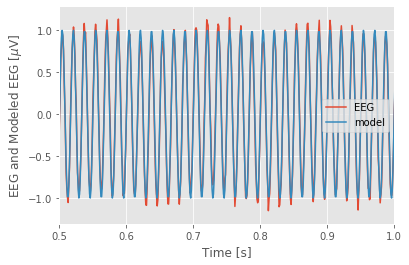

In [51]:
EEG_60Hz_modeled = model.predict()    # Get the model prediction
plot(t, EEG, t, EEG_60Hz_modeled)     # Plot the data and the model
plt.xlim([0.5, 1])                    # ... examine 0.5 s of data,
xlabel('Time [s]')                    # ... and label the axes
ylabel('EEG and Modeled EEG [$\mu$V]')
plt.legend(['EEG', 'model'])
show()

The model, which contains only three predictors, appears to do quite a good job at capturing the 60 Hz activity in the EEG data.

<div class="question">
    
**Q.** The multiple linear regression model <a href="#eq:3.12" class="thumb"><span><img src="imgs/eq3-12.png"></span></a> is not a *perfect* fit ot the data. Why?

**A.** The multiple linear regression model includes only three predictors. We expect the EEG data to consist of other features, including rhythms at other frequencies. Therefore, this simple model cannot account for all features of the EEG time series. That’s okay. The goal of this model was to fit a particular rhythm, the 60 Hz activity, not every aspect of the data.
    
</div>

Now, let's examine a powerful application of the model. We've constructed the model to fit the 60 Hz line noise in the EEG data. Let's now use the model to *remove* the 60 Hz line noise from the original EEG data. To do so, we subtract the model fit from the EEG data and then plot the resulting new signal: <a id="fig:3.9"></a>

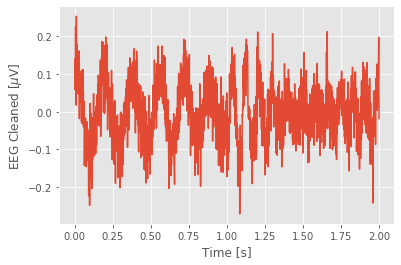

In [52]:
# Remove the model prediction from the EEG data
EEG_cleaned = EEG - EEG_60Hz_modeled
plot(t, EEG_cleaned)  # ... and plot the result
xlabel('Time [s]')
ylabel('EEG Cleaned [$\mu$V]')
show()

<div class="question">
    
**Q.** Consider the cleaned EEG data. What activity do you now notice? Compare the EEG data in the plot you created above to the [original EEG data](#fig:3-1), which includes the 60 Hz noise.<span class="sup">fig<img src="imgs/3-1.png"></span> What’s different?
    
</div>

In this example, we used multiple linear regression to model a particular rhythmic component of the EEG data, the 60 Hz activity. We may also use the model result to estimate the power at 60 Hz. In Python,

In [53]:
Sxx_model_60Hz = model.params['sin'] ** 2 + model.params['cos'] ** 2
Sxx_model_60Hz

0.9978524145209726

The power estimate from the model consists of two terms: the squared coefficient of the sine function plus the squared coefficient of the cosine function. Note that the variable `Sxx_model_60Hz` has units of mV$^2$.

<div class="question">
    
**Q.** Compare the power estimate from the model (the variable `Sxx_model_60Hz`) to the power spectral density at 60 Hz computed using the Fourier transform. What do you find?

**A.** We note that the units of the power spectral density (variable `Sxx`) are mV$^2/$Hz, while the units of the power estimated in variable `Sxx_model_60Hz` are mV$^2$. To convert the power spectral density to (integrated) spectral power, we must integrate the variable `Sxx` over a frequency range. Here, we choose a 1 Hz interval centered at 60 Hz, which corresponds to a single index of the variable `faxis`; the frequency resolution for these data is $\pm 0.5$ Hz. Then the approximate integrated power over this 1 Hz interval can be computed as `Sxx[np.where(faxis == 60)]`, which equals 0.9978, identical to the value in `Sxx_model_60Hz`, and with the same units.
    
</div>

This example, in which we focused on the 60 Hz activity in the EEG, illustrates how we may use multiple linear regression to estimate the power. We could extend this procedure to include additional rhythms in the model beyond 60 Hz (e.g., sine and cosine functions at 1 Hz, 2 Hz, 3 Hz, etc.). In doing so, we would add more terms to the multiple linear regression model and have more $\beta$'s to determine from the data. Multiple linear regression provides a way to decompose the EEG data into sine and cosine functions at different frequencies—just as we proposed to do using the Fourier transform—and then compute the power at each frequency. Using either multiple linear regression or the Fourier transform, we aim to decompose the EEG into sine and cosine functions oscillating at different frequencies.

[Return to top](#top)